## Analyzing CIA Factbook Data
#### SQLite and Python
In this project, I will be analyzing data from the CIA World Factbook (https://www.cia.gov/library/publications/the-world-factbook/) which contains information about statistics concerning all countries on Earth. For example, the Factbook contrains data about population, population growth, area of land and water in a country, and more.

In [11]:
# import relevant packages
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

First, we want to look at the information about the tables contained in the CIA World Factbook database, factbook.db:

In [2]:
# get information about the tables in the database
conn = sqlite3.connect("factbook.db")
query = '''
        SELECT * 
        FROM sqlite_master 
        WHERE type = 'table';
        '''
pd.read_sql_query(query, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


From the query above, we can see that we should be using the table called 'facts' to query the data we are looking for.

Next, we will run a query to explore the head of the facts table:

In [3]:
# first five rows of facts table
query = '''
        SELECT * 
        FROM facts
        LIMIT 5'''
pd.read_sql_query(query, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


From the above query we see there are 11 columns in the table of varying data types. From here we can start to explore by gathering summary statistics of the data:

In [4]:
# Min and max population, min and max population growth
query = '''
        SELECT MIN(population),
               MAX(population),
               MIN(population_growth),
               MAX(population_growth)
               FROM facts
        '''
pd.read_sql_query(query, conn)

,MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,0,7256490011,0.0,4.02


The above summary statistics raise some concerns:
1. The query suggests that at least one country have a population of 0
2. The query suggests that a country has more than 7 billion people

To look into these concerns further, we'll see which countries these outliers are connected to:

In [5]:
# country with population of 0
query = '''
        SELECT name
        FROM facts
        WHERE population = (
                            SELECT MIN(population)
                            FROM facts
                            )
        '''
pd.read_sql_query(query, conn)

,name
0,Antarctica


In [6]:
# country with population of 7.2 billion
query = '''
        SELECT name
        FROM facts
        WHERE population = (
                            SELECT MAX(population)
                            FROM facts
                            )
        '''
pd.read_sql_query(query, conn)

,name
0,World


From the above queries, we now see that the country with no population is Antarctica, which makes sense because nobody is a permanent resident of that country.

Additionally, we see that the population of 7.2 billion was the world population, not a specific country's population.

Knowing this, we should ignore name = 'Antarctica' and name = 'World' in our subsequent analyses.

### Visualization of Population, Population Growth, Birth Rate, and Death Rate

To further explore the distribution of data for the non-outlier countries, let's create histograms of the columns for population, population growth, birth rate, and death rate.

In [13]:
# SQL query to create table, turn into pandas dataframe
query = '''
    SELECT population, 
           population_growth, 
           birth_rate, 
           death_rate 
    FROM facts
'''
hist_data = pd.read_sql_query(query, conn)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f953d4bca20>,
      dtype=object)

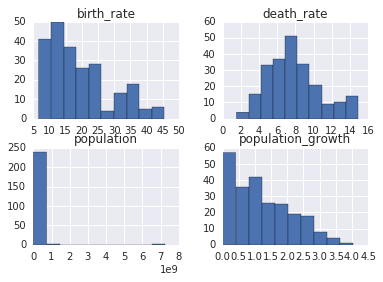

In [17]:
%matplotlib inline
# create histograms
hist_data.hist()

### Which countries have the highest population density?

Population density is the ratio of population to land area.

In order to find which countries have the highest population density, we will first need to calculate the population densities for each country, excluding Antarctica and World. Then we can sort the table by population density in descending order.

Because we have multiple steps in this problem (excluding certain countries and calculating population density), **subqueries** will come in handy for this SQL problem. We will also need to cast some columns as floating data types in order to make the division operation possible.

We'll limit the results to the first 10 countries with the highest population densities.

In [15]:
query = '''
        SELECT name AS country,
               CAST(population AS Float)/ CAST(area_land AS Float) AS population_density
        FROM (
              SELECT *
              FROM facts
              WHERE name NOT IN ("Antarctica", "World")
              )
        ORDER BY population_density DESC
        LIMIT 10
        '''
pd.read_sql_query(query, conn)

,country,population_density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8259.784571
3,Hong Kong,6655.271202
4,Gaza Strip,5191.819444
5,Gibraltar,4876.333333
6,Bahrain,1771.859211
7,Maldives,1319.640940
8,Malta,1310.015823
9,Bermuda,1299.925926


To further explore the data, let's create a histogram to show the distribution of population densities amongst countries:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f953d4b64e0>]],
      dtype=object)

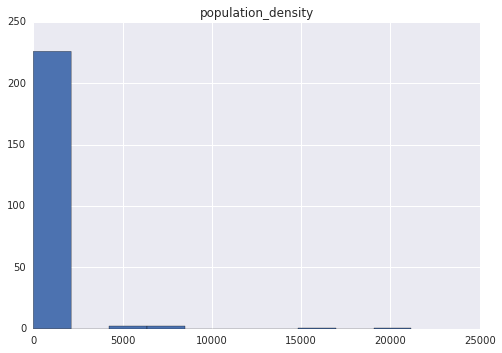

In [16]:
query = '''
        SELECT name AS country,
               CAST(population AS Float)/ CAST(area_land AS Float) AS population_density
        FROM (
              SELECT *
              FROM facts
              WHERE name NOT IN ("Antarctica", "World")
              )
        ORDER BY population_density DESC
        '''
pd.read_sql_query(query, conn).hist()

It's evident that the default bins for this histogram put the vast majority of the data into just one bin! It would be more useful to us to explore which bin parameter makes for the most informative visualization.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f953c9dde80>]],
      dtype=object)

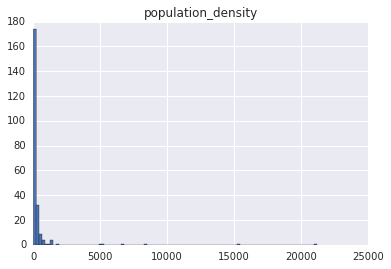

In [23]:
# run same query, but plot with more bins
pd.read_sql_query(query, conn).hist(bins=100)

### Which countries have the highest ratios of water to land?

For this query, we will calculate the ratio of area_water to area_land by casting the columns as floating numbers, and ordering by the water-to-land ratio in descending order. We will return the 10 countries with the highest ratios.

In [26]:
query = """
        SELECT name AS country,
               CAST(area_water AS Float) / CAST(area_land AS Float) AS water_to_land_ratio
        FROM facts
        ORDER BY 2 DESC
        LIMIT 10
        """
pd.read_sql_query(query, conn)

,country,water_to_land_ratio
0,British Indian Ocean Territory,905.666667
1,Virgin Islands,4.520231
2,Puerto Rico,0.554791
3,"Bahamas, The",0.386613
4,Guinea-Bissau,0.284673
5,Malawi,0.259396
6,Netherlands,0.225710
7,Uganda,0.222922
8,Eritrea,0.164356
9,Liberia,0.156240


### Which countries have more water than land?

For this query, we are simply comparing area_water to area_land. We don't need to limit this query because there are only two countries that qualify!

In [27]:
query = """
        SELECT name AS country,
               area_water,
               area_land
        FROM facts
        WHERE area_water > area_land
        """
pd.read_sql_query(query, conn)

,country,area_water,area_land
0,British Indian Ocean Territory,54340,60
1,Virgin Islands,1564,346
